## <u>Part One - PROJECT BASED </u>

• <b>DOMAIN:</b> Entertainment 

• <b>CONTEXT:</b> : Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

• <b>DATA DESCRIPTION:</b> The dataset comprises of images and its mask where there is a human face.

• <b>PROJECT OBJECTIVE:</b> Face detection from training images.

<b>Steps and tasks: [ Total Score:30 points] </b>

1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:<br>
    • Design a face mask detection model.<br>
 Hint: Use U-net along with pre-trained transfer learning models<br>
    • Design your own Dice Coefficient and Loss function. <br>
    • Train, tune and test the model.<br>
    • Evaluate the model using testing data.
4.  Use the “Prediction image” as an input to your designed model and display the output of the image.

<br>

### <u>Solution</u>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import libraries
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.0'

In [3]:
import random
random.seed(0)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall,Precision
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate



###Import the dataset

In [5]:
face_data = np.load('/content/drive/MyDrive/AIML/Labs/CV/Part 1- Train data - images.npy',allow_pickle=True)

In [6]:

#Shape of our loaded dataset
face_data.shape

(409, 2)

Our dataset contains 409 data points/rows and 2 columns.

In [7]:
#Lets look at some of the data values
face_data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [8]:
face_data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

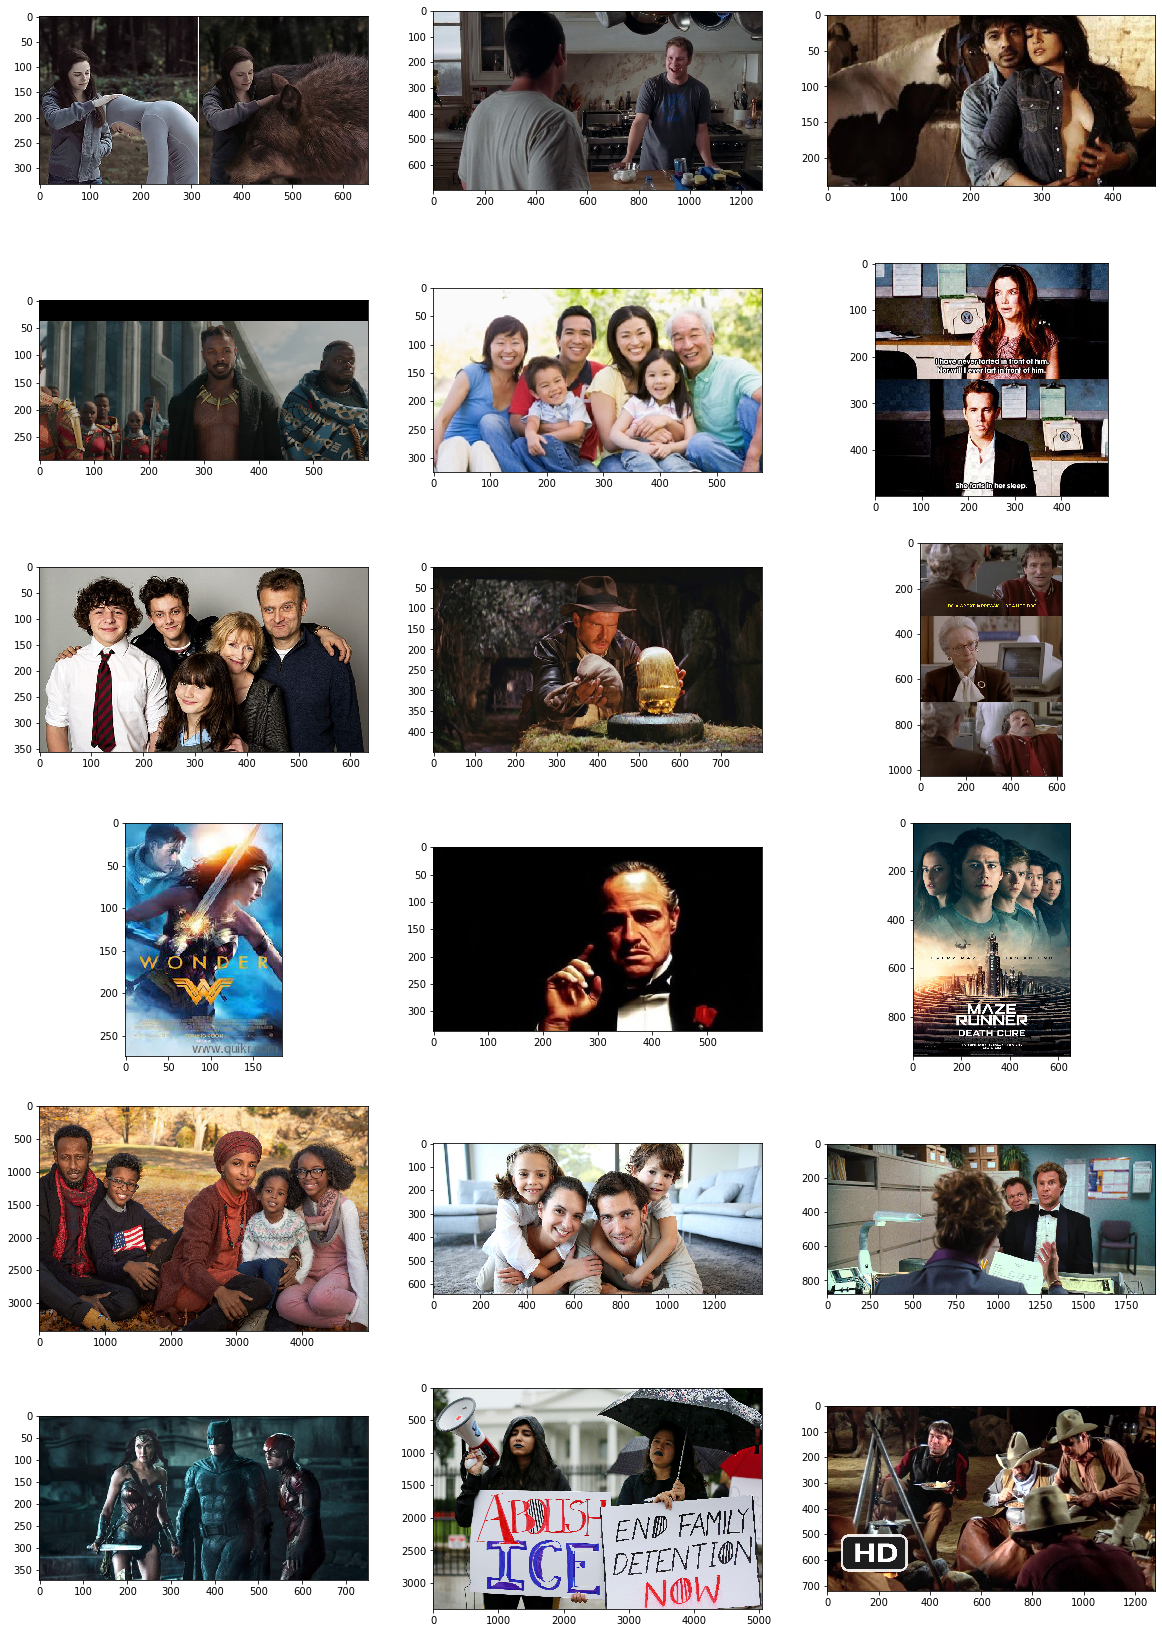

In [9]:
#From above we can see the attributes of each image, lets visualize these images
#Below is a simple loop to view the first 18 images of the dataset
fi,ax = plt.subplots(6,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(18):
  ax[row][col].imshow(face_data[index][0], interpolation='nearest')
  
  index = index + 1
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

###Create features (images) and labels (mask) using that data


In [10]:
#Lets create features and labels 
masks = np.zeros((int(face_data.shape[0]), 224, 224))
X = np.zeros((int(face_data.shape[0]),224, 224, 3))
for i in range(face_data.shape[0]):
  img = face_data[i][0]
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
#Lets remove alpha channel
  try:
    img = img[:,:,:3]
    #print("Entered try state:",i)
  except:
    print(f"Exception {i} Grayscale image with shape {img.shape}")
    #Converting the grayscale to colour
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[i] = preprocess_input(np.array(img, dtype=np.float32))
  # Traversing through face co-ordinates and create mask out of it.
  for j in face_data[i][1]:
    x1 = int(j['points'][0]['x'] * 224)
    x2 = int(j['points'][1]['x'] * 224)
    y1 = int(j['points'][0]['y'] * 224)
    y2 = int(j['points'][1]['y'] * 224)
    # set all pixels within the mask co-ordinates to 1.
    masks[i][y1:y2, x1:x2] = 1
print(f"\nShape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")


Exception 272 Grayscale image with shape (224, 224)

Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [11]:
#Now for our model build we can split our data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.3)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.3)



In [12]:
print(f"Shape of X_train is '{X_train.shape}' \nThe shape of y_train is '{y_train.shape}'\n")
print(f"Shape of X_val is '{X_val.shape}' \nThe shape of y_val is '{y_val.shape}'\n")
print(f"Shape of X_test is '{X_test.shape}' \nThe shape of y_test is '{y_test.shape}'")

Shape of X_train is '(286, 224, 224, 3)' 
The shape of y_train is '(286, 224, 224)'

Shape of X_val is '(86, 224, 224, 3)' 
The shape of y_val is '(86, 224, 224)'

Shape of X_test is '(37, 224, 224, 3)' 
The shape of y_test is '(37, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


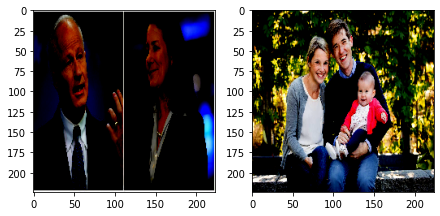

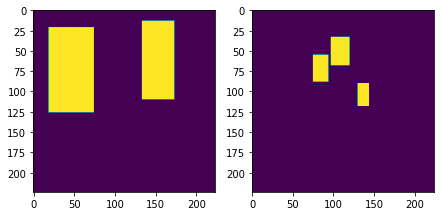

In [13]:
#We can visualize samples our train and test data
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[3])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[16])
imgplot.set_clim(0.0, 0.7)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[3])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[16])
imgplot.set_clim(0.0, 0.7)

From above we can clearly see it has detected the faces

###Design a face mask detection model.

In [14]:
#User defined model
def model():
    inputs = Input(shape=(224, 224, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [15]:
model = model() # Calling the function
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

###Design your own Dice Coefficient and Loss function.

In [16]:
#Defining Dice Coefficient in user defined function
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1e-15) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-15)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
#Now Lets compile the model
opt = tf.keras.optimizers.Nadam(1e-4)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [18]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

###Train, tune and test the model.

In [19]:
#Lets train our model
train_steps = len(X_train)//8
valid_steps = len(X_val)//8

if len(X_train) % 8 != 0:
    train_steps += 1
if len(X_val) % 8 != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
36/36 [==============================] - 23s 148ms/step - loss: 0.7372 - dice_coef: 0.2621 - recall: 0.6891 - precision: 0.2149 - val_loss: 0.7401 - val_dice_coef: 0.2604 - val_recall: 1.0000 - val_precision: 0.1337 - lr: 1.0000e-04
Epoch 2/30
36/36 [==============================] - 3s 88ms/step - loss: 0.6219 - dice_coef: 0.3792 - recall: 0.8813 - precision: 0.3855 - val_loss: 0.7167 - val_dice_coef: 0.2840 - val_recall: 0.9979 - val_precision: 0.1598 - lr: 1.0000e-04
Epoch 3/30
36/36 [==============================] - 3s 87ms/step - loss: 0.5767 - dice_coef: 0.4230 - recall: 0.8967 - precision: 0.4505 - val_loss: 0.6996 - val_dice_coef: 0.3012 - val_recall: 0.9926 - val_precision: 0.1947 - lr: 1.0000e-04
Epoch 4/30
36/36 [==============================] - 3s 90ms/step - loss: 0.5583 - dice_coef: 0.4401 - recall: 0.8900 - precision: 0.4901 - val_loss: 0.6753 - val_dice_coef: 0.3254 - val_recall: 0.9853 - val_precision: 0.2393 - lr: 1.0000e-04
Epoch 5/30
36/36 [============

###Evaluate the model using testing data.

In [20]:
#Evalutaing the model
test_steps = (len(X_test)//8)
if len(X_test) % 8 != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

5/5 [==============================] - 0s 114ms/step - loss: 0.4642 - dice_coef: 0.5393 - recall: 0.5678 - precision: 0.7666


[0.464171439409256, 0.5393009781837463, 0.5678029656410217, 0.7666152119636536]

The model is showing a precion of 62.4% and recall of  73.3% respectively. The loss for the model is  45.8% and coeffiecient is 54.5%

### Use the “Prediction image” as an input to your designed model and display the output of the image

In [21]:
new_img =  cv2.imread('/content/drive/MyDrive/AIML/Labs/CV/Part 1Test Data - Prediction Image.jpeg')
new_img_resized = cv2.resize(new_img, (224,224))
new_scaled = preprocess_input(np.array(new_img_resized, dtype=np.float32))

In [22]:
#Model prediction
y_pred = model.predict(np.array([new_scaled]))
y_pred #Displaying the values in the new prediction

array([[[[0.14897467],
         [0.09187911],
         [0.08548573],
         ...,
         [0.1144352 ],
         [0.1030642 ],
         [0.13947529]],

        [[0.10479578],
         [0.07933868],
         [0.07843505],
         ...,
         [0.0963393 ],
         [0.0950504 ],
         [0.09256692]],

        [[0.10027551],
         [0.08607168],
         [0.08513092],
         ...,
         [0.09348962],
         [0.09657492],
         [0.11485035]],

        ...,

        [[0.11624707],
         [0.10657027],
         [0.10139873],
         ...,
         [0.0955431 ],
         [0.08360979],
         [0.07781216]],

        [[0.12448979],
         [0.10710262],
         [0.07716419],
         ...,
         [0.07079967],
         [0.06629608],
         [0.07742494]],

        [[0.12486342],
         [0.09648819],
         [0.07833749],
         ...,
         [0.08090868],
         [0.08519086],
         [0.09574417]]]], dtype=float32)

In [23]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (224,224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


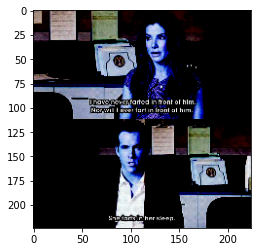

In [24]:
#Lets visualize our prediction image and our face detect output
plt.imshow(new_scaled) #Our input

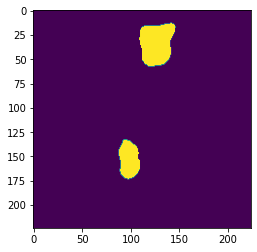

In [25]:
plt.imshow(pred_mask)

Our model managed to correctly detect the two faces in the image.

## <u>Part Two - PROJECT BASED </u>

• <b>DOMAIN:</b> Face recognition

• <b> CONTEXT:</b> Company X intends to build a face identification model to recognise human faces.

• <b>DATA DESCRIPTION:</b>  The dataset comprises of images and its mask where there is a human face.

• <b>PROJECT OBJECTIVE:</b> Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

• <b>TASK:</b> In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly
interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project. 

• Load the dataset and create the metadata.<br>
• Check some samples of metadata.<br>
• Load the pre-trained model and weights.<br>
• Generate Embedding vectors for each face in the dataset.<br>
• Build distance metrics for identifying the distance between two given images.<br>
• Use PCA for dimensionality reduction.<br>
• Build an SVM classifier in order to map each image to its right person.<br>
• Import the the test image. Display the image. Use the SVM trained model to predict the face.

### <u>Solution</u>

In [26]:
from zipfile import ZipFile
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

In [27]:
#cd '/content/drive/MyDrive/AIML/Labs/CV/Test'

In [28]:
import shutil
try:
 shutil.rmtree("/content/pins")
 shutil.rmtree("/content/PINS")
except:
 print('')

In [29]:
#We need to extract all the files
path = "/content/drive/MyDrive/AIML/Labs/CV/"
zip_path = path + "Part 3 - Aligned Face Dataset from Pinterest.zip"
with ZipFile(zip_path,'r') as zip:
  #Extracting all the files
  zip.extractall()


In [30]:
print(zip.namelist()[4])#Sample path

PINS/pins_Aaron Paul/Aaron Paul103_217.jpg


In [31]:
directory = "/content/pins/PINS/"
for li in os.listdir(directory):
  os.rename(os.path.join(directory,li), os.path.join(directory, li.replace(' ', '_').upper()))
for name in os.listdir(directory):  
  
  wd = "PINS_"
  if wd in name:
    #print(name)
    file_path = os.path.join(directory, name)
    new_path = os.path.join(directory, name.replace(wd, ""))
    os.rename(file_path, new_path)

for subdir, dirs, files in os.walk(directory):
   for item in files:
    os.rename(os.path.join(subdir, item), os.path.join(subdir, item.replace(' ', '_')))
   

In [32]:
#Now since we have renamed the folder lets store the label names and display it 

paths = glob.glob("/content/pins/PINS/*")
label_names = [os.path.split(x)[1] for x in paths]
print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 100
Labels: ['WILLIAM_FICHTNER', 'MARGOT_ROBBIE_FACE', 'DOMINIC_PURCELL', 'CHRIS_PRATT', 'BRYAN_CRANSTON', 'CAMERON_MONAGHAN', 'BELLAMY_BLAKE_FACE', 'RAMI_MELEK', 'SEBASTIAN_STAN', 'MORGAN_FREEMAN', 'DWAYNE_JOHNSON', 'BARBARA_PALVIN_FACE', 'BETSY_BRANDT', 'EMILIA_CLARKE', 'LINDSEY_MORGAN_FACE', 'CHANCE_PERDOMO', 'EMMA_WATSON_FACE', 'COBIE_SMULDERS', 'SUNDAR_PICHAI', 'MARK_RUFFALO', 'EMMA_STONE', 'RJ_MITTE', 'JASON_ISAACS', 'ELIZABETH_OLSEN_FACE', 'BENEDICT_CUMBERBATCH', 'KIT_HARINGTON', 'MIGUEL_HERRAN', 'MARK_ZUCKERBERG', 'DANIELLE_PANABAKER', 'KUMAIL_NANJIANI', 'RYAN_REYNOLDS', 'WENTWORTH_MILLER', 'THOMAS_MIDDLEDITCH', 'GAL_GADOT_FACE', 'JEREMY_RENNER', 'JASON_MOMOA', 'ALVARO_MORTE', 'SHAKIRA', 'TOM_HOLLAND_FACE', 'ELIZA_TAYLOR', 'TAYLOR_SWIFT', 'PAUL_RUDD', 'PETER_DINKLAGE', 'WILLA_HOLLAND', 'AMANDA_CREW', 'AMAURY_NOLASCO', 'MILLIE_BOBBY_BROWN', 'CHADWICK_BOSEMAN_FACE', 'SARAH_WAYNE_CALLIES', 'ROBERT_KNEPPER', 'PEDRO_ALONSO', 'JOSH_RADNOR', 'BRENTON_THWAITES', 'NEIL_PAT

In [33]:
#Lets extract the meta data and store it in dataframe
df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])
folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
  
  fileList = os.listdir(subfolders)
  filePath = os.path.abspath(subfolders)
  person = (subfolders)[len(directory):]
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df

,Person,No. of Images,File Path,Files
0,,100,/content/pins/PINS,"[WILLIAM_FICHTNER, MARGOT_ROBBIE_FACE, DOMINIC..."
1,WILLIAM_FICHTNER,139,/content/pins/PINS/WILLIAM_FICHTNER,"[William_Fichtner92.jpg, William_Fichtner87.jp..."
2,MARGOT_ROBBIE_FACE,140,/content/pins/PINS/MARGOT_ROBBIE_FACE,"[margot_robbie_face54.jpg, margot_robbie_face2..."
3,DOMINIC_PURCELL,107,/content/pins/PINS/DOMINIC_PURCELL,"[Dominic_Purcell37.jpg, Dominic_Purcell83.jpg,..."
4,CHRIS_PRATT,141,/content/pins/PINS/CHRIS_PRATT,"[Chris_Pratt35.jpg, Chris_Pratt82.jpg, Chris_P..."
...,...,...,...,...
96,BRIT_MARLING,122,/content/pins/PINS/BRIT_MARLING,"[Brit_Marling127_481.jpg, Brit_Marling121_519...."
97,ROBIN_TAYLOR,99,/content/pins/PINS/ROBIN_TAYLOR,"[Robin_Taylor14.jpg, Robin_Taylor3.jpg, Robin_..."
98,AMBER_HEARD_FACE,151,/content/pins/PINS/AMBER_HEARD_FACE,"[amber_heard_face7.jpg, amber_heard_face50.jpg..."
99,HENRY_CAVIL,134,/content/pins/PINS/HENRY_CAVIL,"[Henry_Cavil127.jpg, Henry_Cavil114.jpg, Henry..."


In [34]:
TRAIN_FOLDER= "/content/pins/PINS/"
from glob import glob

images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [35]:
len(images)

10770

In [36]:
# resize image and storing
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

images = [resize_images(img) for img in images]

In [37]:
#Shape of images & number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


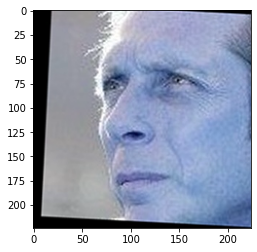

In [38]:
plt.imshow(images[22])


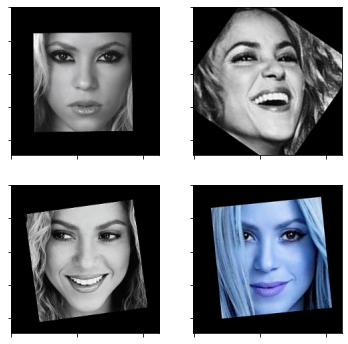

In [39]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("SHAKIRA")

In [40]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(directory)

In [41]:
pip show keras-vggface


Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: keras, pillow, numpy, h5py, scipy, six, pyyaml
Required-by: 


In [42]:
pip install keras_vggface

In [43]:
weights_file = '/content/drive/MyDrive/AIML/Labs/CV/Part 3 - vgg_face_weights.h5'


In [44]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

In [45]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [46]:
pip install mtcnn


In [47]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [48]:
cd '/content/pins/PINS'

/content/pins/PINS


In [49]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [50]:
def converter(path):
 bgr = cv2.imread(path, cv2.IMREAD_COLOR)
 t = np.array(bgr).astype(np.uint8)
 out = cv2.resize(t,(224,224), interpolation = cv2.INTER_CUBIC)
 return out

In [51]:
from mtcnn.mtcnn import MTCNN
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
img_path = '/content/pins/PINS/AARON_PAUL/Aaron_Paul0_262.jpg'

  

out = converter(img_path)

faces = detector.detect_faces(out)
for face in faces:
  print(face)

{'box': [9, 0, 214, 232], 'confidence': 0.9996857643127441, 'keypoints': {'left_eye': (78, 57), 'right_eye': (173, 77), 'nose': (112, 104), 'mouth_left': (59, 152), 'mouth_right': (147, 171)}}


In [52]:
def extract_face(filename, required_size=(224, 224)):
	# load image from file

 #filename_conv = converter(filename)
 pixels = cv2.imread(filename)
 #t = np.array(pixels).astype(np.uint8)
 #out = cv2.resize(t,(224,224), interpolation = cv2.INTER_CUBIC)
 
	# create the detector, using default weights
 detector = MTCNN()
 
  # detect faces in the image
 results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
 x1, y1, width, height = results[0]['box']
 x2, y2 = x1 + width, y1 + height

	# extract the face
 face = pixels[y1:y2, x1:x2]

	# resize pixels to the model size
 image = Image.fromarray(face)
 image = image.resize(required_size)
 face_array = asarray(image)
 return face_array

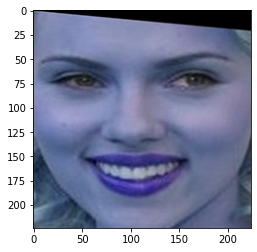

In [53]:
# load the photo and extract the face
from PIL import Image
from numpy import asarray

pixels = extract_face('/content/pins/PINS/SCARLETT_JOHANSSON/Scarlett_Johansson101.jpg')

# plot the extracted face
plt.imshow(pixels)

# show the plot
plt.show()


In [54]:
pip install keras_vggface


In [55]:
pip install keras_applications


In [56]:
try:
  from keras_vggface.utils import preprocess_input
except:
  from keras_vggface.utils import preprocess_input


In [57]:
from numpy import expand_dims
from keras_vggface.utils import preprocess_input

# load the photo and extract the face
pixels = extract_face('/content/pins/PINS/SEBASTIAN_STAN/Sebastian_Stan0.jpg')

# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)

# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

In [58]:
from keras_vggface.utils import decode_predictions

# perform prediction
yhat = vgg_face_descriptor.predict(samples)

# convert prediction into names
results = decode_predictions(yhat)

# display most likely results
for result in results[0]:
	print('%s: %.2f%%' % (result[0], result[1]))

360448/346184 [===============================] - 0s 0us/step
b'Jerry_Ferrara': 9.38%
b'Michael_Ealy': 7.85%
b'Karolina_Wydra': 7.64%
b'Rami_Malek': 7.46%
b'Jesse_Spencer': 7.14%


In [59]:
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)

	# perform prediction
	yhat = vgg_face_descriptor.predict(samples)
	return yhat

In [60]:
# determine if a candidate face is a match for a known face
from scipy.spatial.distance import cosine

def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [61]:
# define filenames
filenames = ['/content/pins/PINS/ZENDAYA/zendaya12.jpg','/content/pins/PINS/ZENDAYA/zendaya20.jpg',
             '/content/pins/PINS/ZENDAYA/zendaya25.jpg','/content/pins/PINS/TOM_HOLLAND_FACE/tom_holland_face1.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define natalie
natalie_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.294 <= 0.500)
>face is a Match (0.319 <= 0.500)
Negative Tests
>face is NOT a Match (0.677 > 0.500)


In [62]:
def L2Norm(H1,H2):
    distance =0
    for i in range(len(H1)):
        distance += np.square(H1[i]-H2[i])
    return np.sqrt(distance)

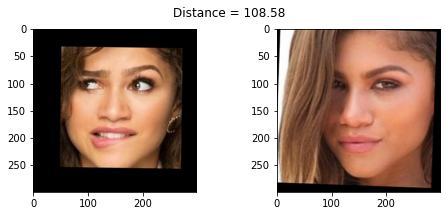

In [63]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {L2Norm(embeddings[0], embeddings[2]):.2f}')
    plt.subplot(121)
    img_1 = plt.imread(filenames[idx1])
    plt.imshow(img_1)
    plt.subplot(122)
    img_2 = plt.imread(filenames[idx2])
    plt.imshow(img_2)    

show_pair(0, 2)